In [ ]:
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

In [ ]:
labels = ['Flooding', 'No Flooding']
train_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/train'
valid_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/valid'
test_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 285 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


# Mobile Net

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224,3), weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
x = mobile.layers[-12].output
x

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'conv_dw_12')>

In [ ]:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=mobile.input, outputs=output)

In [ ]:
  for layer in model.layers[:-23]:
      layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 58s - loss: 1.0088 - accuracy: 0.6491 - val_loss: 0.5447 - val_accuracy: 0.8209 - 58s/epoch - 2s/step
Epoch 2/12
29/29 - 22s - loss: 0.5023 - accuracy: 0.8737 - val_loss: 0.3053 - val_accuracy: 0.8358 - 22s/epoch - 768ms/step
Epoch 3/12
29/29 - 20s - loss: 0.3431 - accuracy: 0.8982 - val_loss: 0.2802 - val_accuracy: 0.8806 - 20s/epoch - 682ms/step
Epoch 4/12
29/29 - 23s - loss: 0.2253 - accuracy: 0.9509 - val_loss: 0.2727 - val_accuracy: 0.8806 - 23s/epoch - 802ms/step
Epoch 5/12
29/29 - 22s - loss: 0.1347 - accuracy: 0.9789 - val_loss: 0.2571 - val_accuracy: 0.8806 - 22s/epoch - 761ms/step
Epoch 6/12
29/29 - 22s - loss: 0.1510 - accuracy: 0.9544 - val_loss: 0.2133 - val_accuracy: 0.8806 - 22s/epoch - 767ms/step
Epoch 7/12
29/29 - 22s - loss: 0.2353 - accuracy: 0.9509 - val_loss: 0.0853 - val_accuracy: 0.9701 - 22s/epoch - 768ms/step
Epoch 8/12
29/29 - 22s - loss: 0.1423 - accuracy: 0.9614 - val_loss: 0.0868 - val_accuracy: 0.9851 - 22s/epoch - 764ms/step
Epoch 9/12


In [ ]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9583333333333334
F1 Score:  0.9583333333333334
Accuracy:  0.9701492537313433


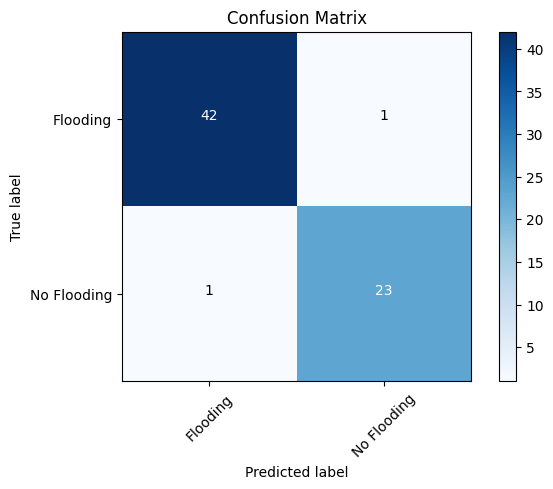

In [ ]:
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
def preprocess_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
from IPython.display import Image

def predict(file):
  preprocessed_image = preprocess_image(file)
  predictions = model.predict(preprocessed_image)
  result = np.argmax(predictions)
  print(labels[result])
  return Image(filename=file, width=300,height=200)

1/1 [==============================] - 0s 52ms/step
Flooding


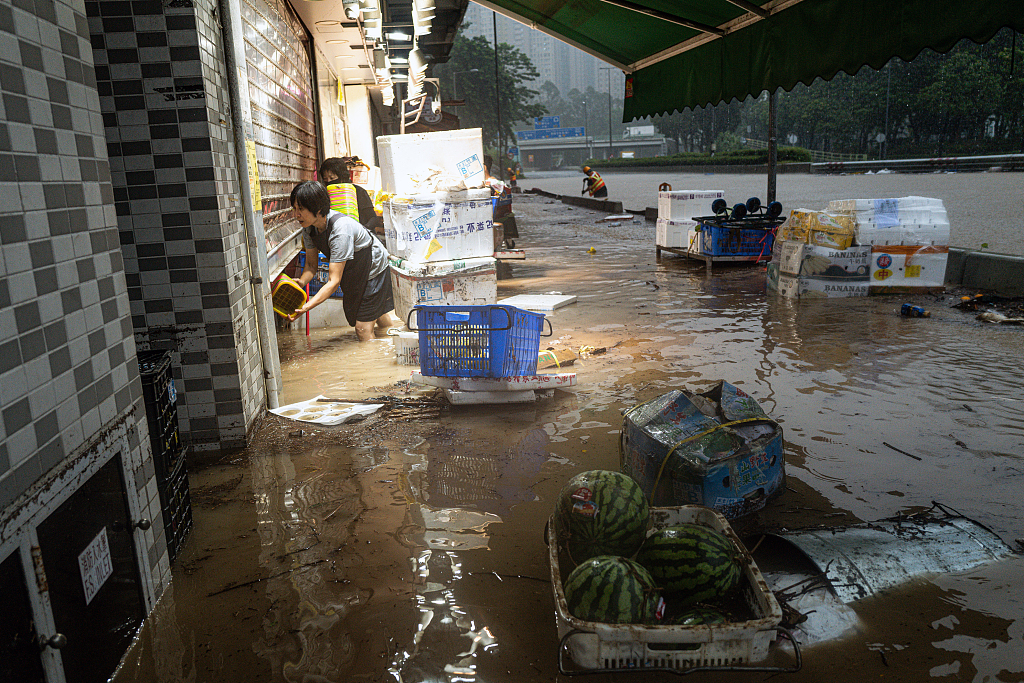

In [ ]:
from tensorflow.keras.preprocessing import image


file = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/test-15.jpeg'

image = predict(file)
display(image)

# InceptionV3

In [ ]:
labels = ['Flooding', 'No Flooding']
train_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/train'
valid_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/valid'
test_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 285 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [ ]:
inception = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),include_top=False,weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
x = inception.layers[-12].output
x

<KerasTensor: shape=(None, 5, 5, 192) dtype=float32 (created by layer 'conv2d_93')>

In [ ]:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = Dense(units=2, activation='softmax')(x)

In [ ]:
model = Model(inputs=inception.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 48s - loss: 0.5422 - accuracy: 0.8456 - val_loss: 0.3766 - val_accuracy: 0.8358 - 48s/epoch - 2s/step
Epoch 2/12
29/29 - 42s - loss: 0.3544 - accuracy: 0.9018 - val_loss: 0.2500 - val_accuracy: 0.8507 - 42s/epoch - 1s/step
Epoch 3/12
29/29 - 42s - loss: 0.2704 - accuracy: 0.9298 - val_loss: 0.2094 - val_accuracy: 0.8657 - 42s/epoch - 1s/step
Epoch 4/12
29/29 - 44s - loss: 0.1617 - accuracy: 0.9474 - val_loss: 0.1860 - val_accuracy: 0.8657 - 44s/epoch - 2s/step
Epoch 5/12
29/29 - 42s - loss: 0.1243 - accuracy: 0.9684 - val_loss: 0.1360 - val_accuracy: 0.9403 - 42s/epoch - 1s/step
Epoch 6/12
29/29 - 42s - loss: 0.0954 - accuracy: 0.9825 - val_loss: 0.1235 - val_accuracy: 0.9552 - 42s/epoch - 1s/step
Epoch 7/12
29/29 - 42s - loss: 0.0731 - accuracy: 0.9825 - val_loss: 0.0910 - val_accuracy: 1.0000 - 42s/epoch - 1s/step
Epoch 8/12
29/29 - 42s - loss: 0.0732 - accuracy: 0.9825 - val_loss: 0.0850 - val_accuracy: 1.0000 - 42s/epoch - 1s/step
Epoch 9/12
29/29 - 41s - loss: 0

In [ ]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9230769230769231
F1 Score:  0.9600000000000001
Accuracy:  0.9701492537313433


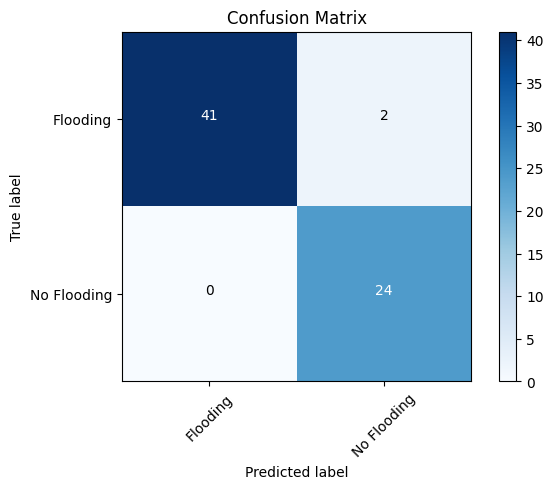

In [ ]:
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
def preprocess_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.inception_v3.preprocess_input(img_array_expanded_dims)

In [ ]:
from IPython.display import Image

def predict(file):
  preprocessed_image = preprocess_image(file)
  predictions = model.predict(preprocessed_image)
  result = np.argmax(predictions)
  print(labels[result])
  return Image(filename=file, width=300,height=200)

1/1 [==============================] - 0s 224ms/step
Flooding


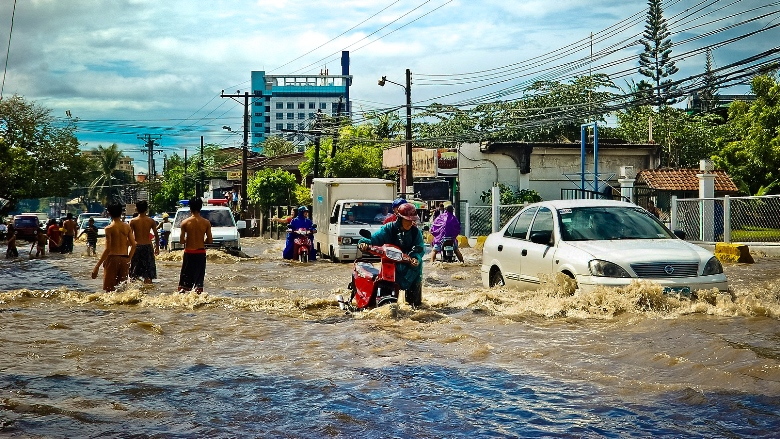

In [ ]:
from tensorflow.keras.preprocessing import image


file = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/test-9.jpg'

image = predict(file)
display(image)

# VGG16

In [ ]:
labels = ['Flooding', 'No Flooding']
train_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/train'
valid_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/valid'
test_path = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 285 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [ ]:
vgg = tf.keras.applications.VGG16(input_shape=(224, 224,3), weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
x = vgg.layers[-12].output
x

<KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv1')>

In [ ]:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=vgg.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 288s - loss: 81.6432 - accuracy: 0.6140 - val_loss: 56.5111 - val_accuracy: 0.4328 - 288s/epoch - 10s/step
Epoch 2/12
29/29 - 269s - loss: 38.2538 - accuracy: 0.6912 - val_loss: 26.2886 - val_accuracy: 0.7164 - 269s/epoch - 9s/step
Epoch 3/12
29/29 - 270s - loss: 25.4555 - accuracy: 0.7368 - val_loss: 14.5511 - val_accuracy: 0.7910 - 270s/epoch - 9s/step
Epoch 4/12
29/29 - 262s - loss: 20.4013 - accuracy: 0.7439 - val_loss: 9.2772 - val_accuracy: 0.8209 - 262s/epoch - 9s/step
Epoch 5/12


In [ ]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

In [ ]:
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
def preprocess_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.inception_v3.preprocess_input(img_array_expanded_dims)

In [ ]:
from IPython.display import Image

def predict(file):
  preprocessed_image = preprocess_image(file)
  predictions = model.predict(preprocessed_image)
  result = np.argmax(predictions)
  print(labels[result])
  return Image(filename=file, width=300,height=200)

In [ ]:
from tensorflow.keras.preprocessing import image


file = '/content/drive/MyDrive/Thesis/Datasets/MobileNet-CNN/test-9.jpg'

image = predict(file)
display(image)

In [ ]:
print()